In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
df = pd.read_csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")
print(df.shape)
print(df.columns)

(7043, 21)
Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


In [4]:
print(df['Churn'].value_counts(normalize=True))

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


In [5]:
print(df.isna().sum().sort_values(ascending=False).head())

customerID          0
DeviceProtection    0
TotalCharges        0
MonthlyCharges      0
PaymentMethod       0
dtype: int64


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

> **Visualized Churn Yes/No Distribution to check if the data is balanced.**>

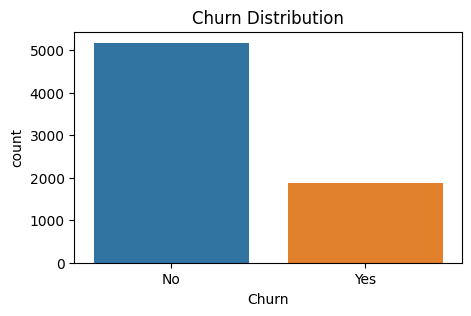

In [7]:
figure_path = '/kaggle/working/figures/'
os.makedirs(figure_path, exist_ok=True)

plt.figure(figsize=(5, 3))
sns.countplot(x='Churn', data=df)

plt.title('Churn Distribution')
fig_title = 'churn_dist.png'
plt.savefig(figure_path+fig_title, dpi=200, bbox_inches='tight')
plt.show()

> **Visualized the relationship between Tenure, Monthly Charges, Total Charges, and Churn.**
> **For Monthly Charges and Total Charges, median values were added.**

In [8]:
print(df['MonthlyCharges'].dtype, df['TotalCharges'].dtype)

float64 object


In [9]:
monthly_medians = df.groupby('Churn')['MonthlyCharges'].median()
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
total_medians = df.groupby('Churn')['TotalCharges'].mean()

print(monthly_medians, type(monthly_medians))
print(total_medians, type(total_medians))

Churn
No     64.425
Yes    79.650
Name: MonthlyCharges, dtype: float64 <class 'pandas.core.series.Series'>
Churn
No     2555.344141
Yes    1531.796094
Name: TotalCharges, dtype: float64 <class 'pandas.core.series.Series'>


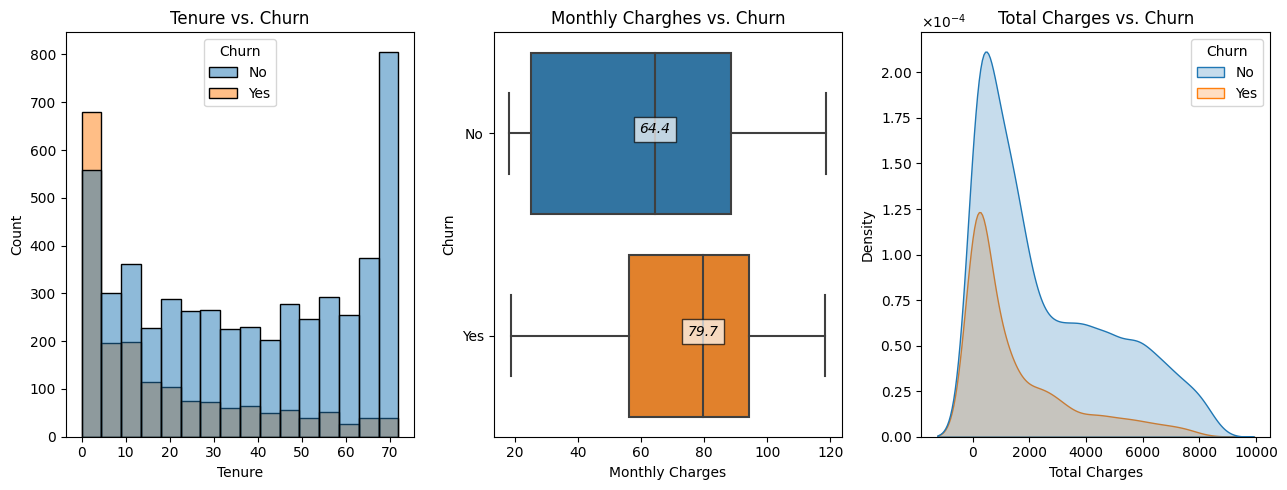

In [10]:
import matplotlib.ticker as mticker

fig, axs = plt.subplots(1, 3, figsize=(13, 5))

sns.histplot(data=df,
             x='tenure', hue='Churn', ax=axs[0])
sns.boxplot(data=df,
            x='MonthlyCharges', y='Churn', showfliers=True, ax=axs[1])
sns.kdeplot(data=df,
            x='TotalCharges', hue='Churn', fill=True, ax=axs[2])

axs[0].set_title('Tenure vs. Churn')
axs[0].set_xlabel('Tenure')
sns.move_legend(axs[0], 'upper center')

axs[1].set_title('Monthly Charghes vs. Churn')
axs[1].set_xlabel('Monthly Charges')
for i, (churn, median) in enumerate(monthly_medians.items()):
    axs[1].text(median, i, f'{median:.1f}',
                ha='center',style='italic',
                bbox=dict(facecolor='white', alpha=0.7))

axs[2].set_title('Total Charges vs. Churn')
axs[2].set_xlabel('Total Charges')
axs[2].yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
axs[2].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

title = 'features_1.png'
fig.tight_layout()
fig.savefig(figure_path+title, dpi=200, bbox_inches='tight')
fig.show()

> **Find any other features having correlated with 'Churn'** <br>
> Other Columns: <br>
> SeniorCitizen, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod

In [11]:
other_columns = ['SeniorCitizen', 'PhoneService', 'MultipleLines', 'InternetService', 
                 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

for col in other_columns:
    print(f"{col}: {df[col].unique().tolist()}")

SeniorCitizen: [0, 1]
PhoneService: ['No', 'Yes']
MultipleLines: ['No phone service', 'No', 'Yes']
InternetService: ['DSL', 'Fiber optic', 'No']
OnlineSecurity: ['No', 'Yes', 'No internet service']
OnlineBackup: ['Yes', 'No', 'No internet service']
DeviceProtection: ['No', 'Yes', 'No internet service']
TechSupport: ['No', 'Yes', 'No internet service']
StreamingTV: ['No', 'Yes', 'No internet service']
StreamingMovies: ['No', 'Yes', 'No internet service']
Contract: ['Month-to-month', 'One year', 'Two year']
PaperlessBilling: ['Yes', 'No']
PaymentMethod: ['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)']


In [12]:
def ratio(group):
    df_ratio = (
        df.groupby(group)['Churn']
        .apply(lambda x: (x=='Yes').mean())
        .reset_index(name='churn_ratio')
    )

    return df_ratio

In [13]:
ratio_ps = ratio('PhoneService')
ratio_ml = ratio('MultipleLines')
ratio_is = ratio('InternetService')
ratio_os = ratio('OnlineSecurity')
ratio_ob = ratio('OnlineBackup')
ratio_dp = ratio('DeviceProtection')
ratio_ts = ratio('TechSupport')
ratio_stv = ratio('StreamingTV')
ratio_smv = ratio('StreamingMovies')
ratio_cont = ratio('Contract')
ratio_pless = ratio('PaperlessBilling')
ratio_pm = ratio('PaymentMethod')

# sns.barplot(data=ratio_ps, x='PhoneService', y='churn_ratio')
# sns.barplot(data=ratio_ml, x='MultipleLines', y='churn_ratio') ##
# sns.barplot(data=ratio_is, x='InternetService', y='churn_ratio')##
# sns.barplot(data=ratio_os, x='OnlineSecurity', y='churn_ratio')##
# sns.barplot(data=ratio_ob, x='OnlineBackup', y='churn_ratio') ##
# sns.barplot(data=ratio_dp, x='DeviceProtection', y='churn_ratio') ##
# sns.barplot(data=ratio_ts, x='TechSupport', y='churn_ratio') ##
# sns.barplot(data=ratio_stv, x='StreamingTV', y='churn_ratio')
# sns.barplot(data=ratio_smv, x='StreamingMovies', y='churn_ratio')
# sns.barplot(data=ratio_cont, x='Contract', y='churn_ratio') ##
# sns.barplot(data=ratio_pless, x='PaperlessBilling', y='churn_ratio') ##
# sns.barplot(data=ratio_pm, x='PaymentMethod', y='churn_ratio') ##

> **Ratio of Customer Churn within categories of features.**

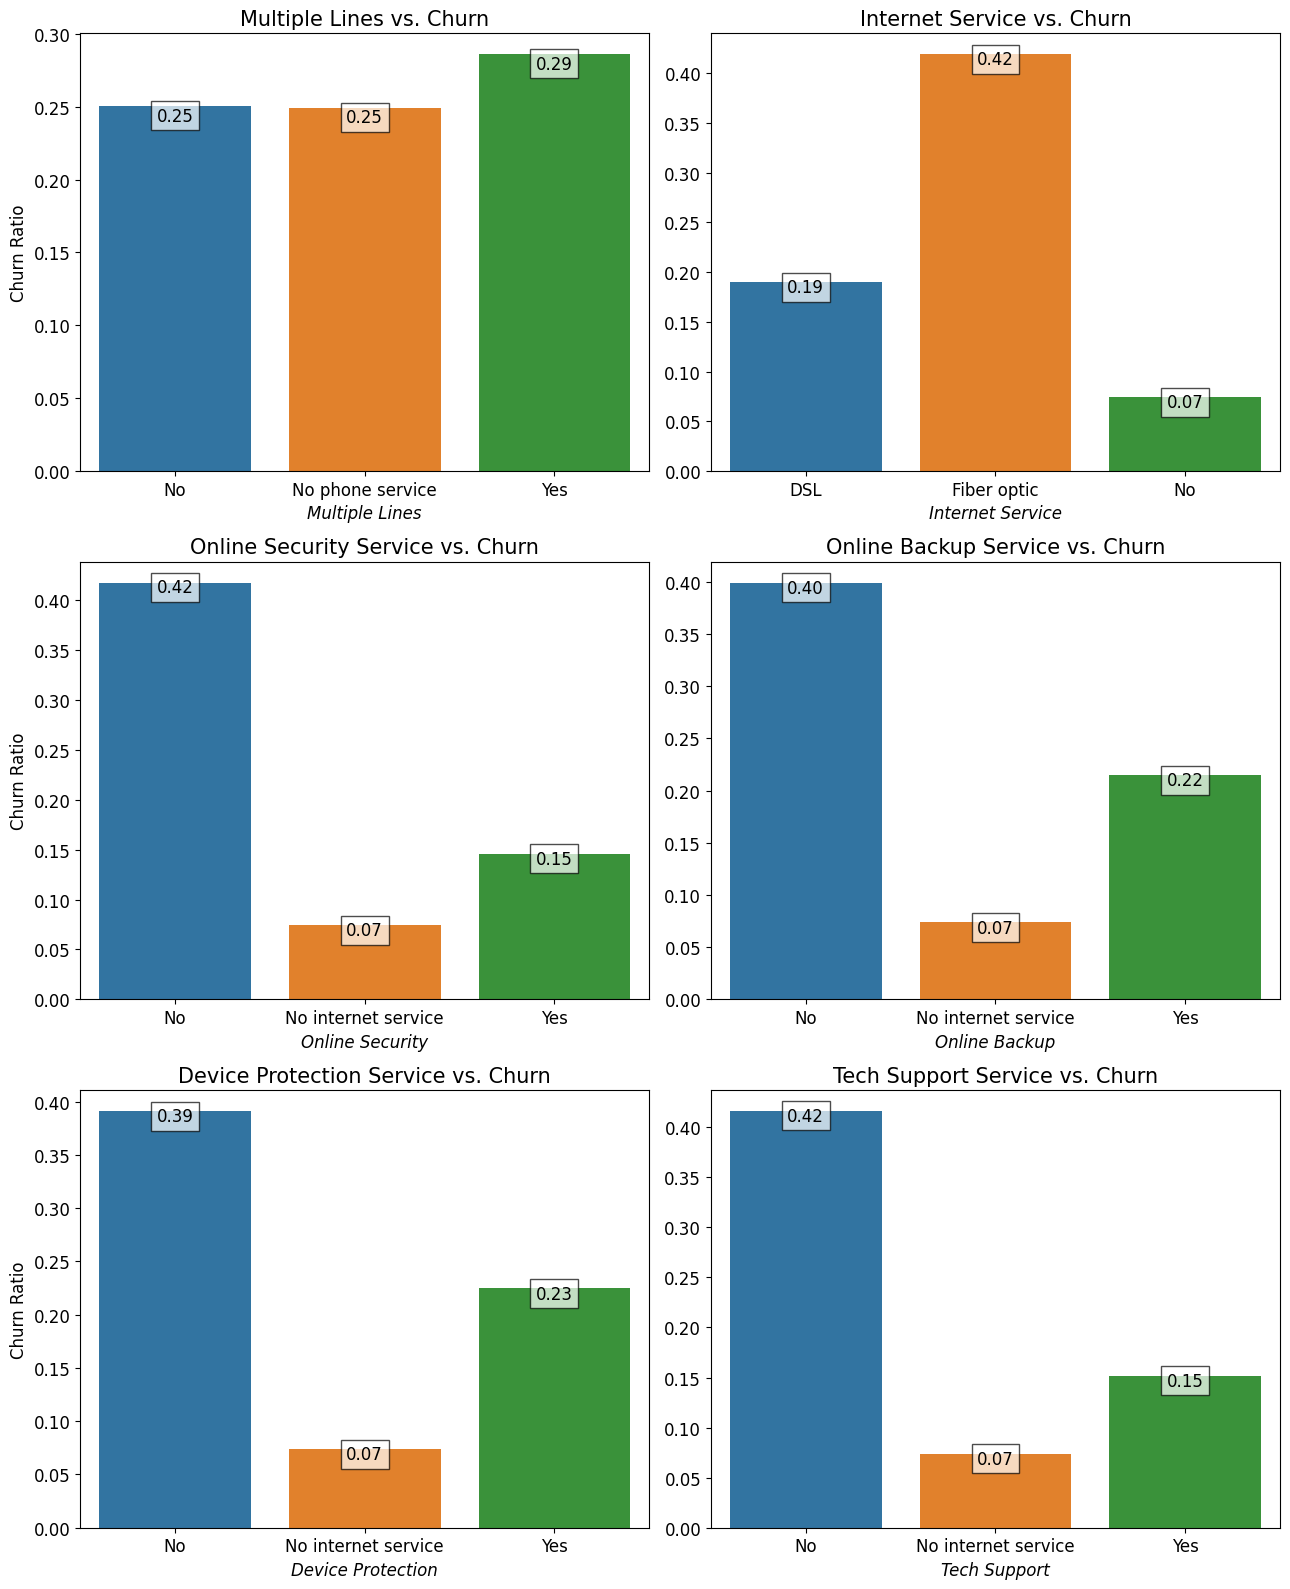

In [14]:
fig, axs = plt.subplots(3, 2, figsize=(13, 16))
sns.barplot(data=ratio_ml, x='MultipleLines', y='churn_ratio', ax=axs[0][0])
sns.barplot(data=ratio_is, x='InternetService', y='churn_ratio', ax=axs[0][1])
sns.barplot(data=ratio_os, x='OnlineSecurity', y='churn_ratio', ax=axs[1][0])
sns.barplot(data=ratio_ob, x='OnlineBackup', y='churn_ratio', ax=axs[1][1])
sns.barplot(data=ratio_dp, x='DeviceProtection', y='churn_ratio', ax=axs[2][0])
sns.barplot(data=ratio_ts, x='TechSupport', y='churn_ratio', ax=axs[2][1])


axs[0][0].set_title('Multiple Lines vs. Churn', fontsize=15)
axs[0][0].set_xlabel('Multiple Lines', fontsize=12, style='italic')
axs[0][0].set_ylabel('Churn Ratio', fontsize=12)

axs[0][1].set_title('Internet Service vs. Churn', fontsize=15)
axs[0][1].set_xlabel('Internet Service', fontsize=12, style='italic')
axs[0][1].set_ylabel('')

axs[1][0].set_title('Online Security Service vs. Churn', fontsize=15)
axs[1][0].set_xlabel('Online Security', fontsize=12, style='italic')
axs[1][0].set_ylabel('Churn Ratio', fontsize=12)

axs[1][1].set_title('Online Backup Service vs. Churn', fontsize=15)
axs[1][1].set_xlabel('Online Backup', fontsize=12, style='italic')
axs[1][1].set_ylabel('')

axs[2][0].set_title('Device Protection Service vs. Churn', fontsize=15)
axs[2][0].set_xlabel('Device Protection', fontsize=12, style='italic')
axs[2][0].set_ylabel('Churn Ratio', fontsize=12)

axs[2][1].set_title('Tech Support Service vs. Churn', fontsize=15)
axs[2][1].set_xlabel('Tech Support', fontsize=12, style='italic')
axs[2][1].set_ylabel('')

for i in range(3):
    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=12)
        axs[i][j].tick_params(axis='y', labelsize=12)

for i, r in enumerate(ratio_ml['churn_ratio']):
    axs[0][0].text(i, r-0.01, f'{r:.2f}', ha='center', fontsize=12,
                   bbox=dict(facecolor='white', alpha=0.7))

for i, r in enumerate(ratio_is['churn_ratio']):
    axs[0][1].text(i, r-0.01, f'{r:.2f}', ha='center', fontsize=12,
                   bbox=dict(facecolor='white', alpha=0.7))
    
for i, r in enumerate(ratio_os['churn_ratio']):
    axs[1][0].text(i, r-0.01, f'{r:.2f}', ha='center', fontsize=12,
                   bbox=dict(facecolor='white', alpha=0.7))

for i, r in enumerate(ratio_ob['churn_ratio']):
    axs[1][1].text(i, r-0.01, f'{r:.2f}', ha='center', fontsize=12,
                   bbox=dict(facecolor='white', alpha=0.7))

for i, r in enumerate(ratio_dp['churn_ratio']):
    axs[2][0].text(i, r-0.01, f'{r:.2f}', ha='center', fontsize=12,
                   bbox=dict(facecolor='white', alpha=0.7))

for i, r in enumerate(ratio_ts['churn_ratio']):
    axs[2][1].text(i, r-0.01, f'{r:.2f}', ha='center', fontsize=12,
                   bbox=dict(facecolor='white', alpha=0.7))

title = 'features_2.png'
fig.tight_layout()
fig.savefig(figure_path+title, dpi=200, bbox_inches='tight')
fig.show()

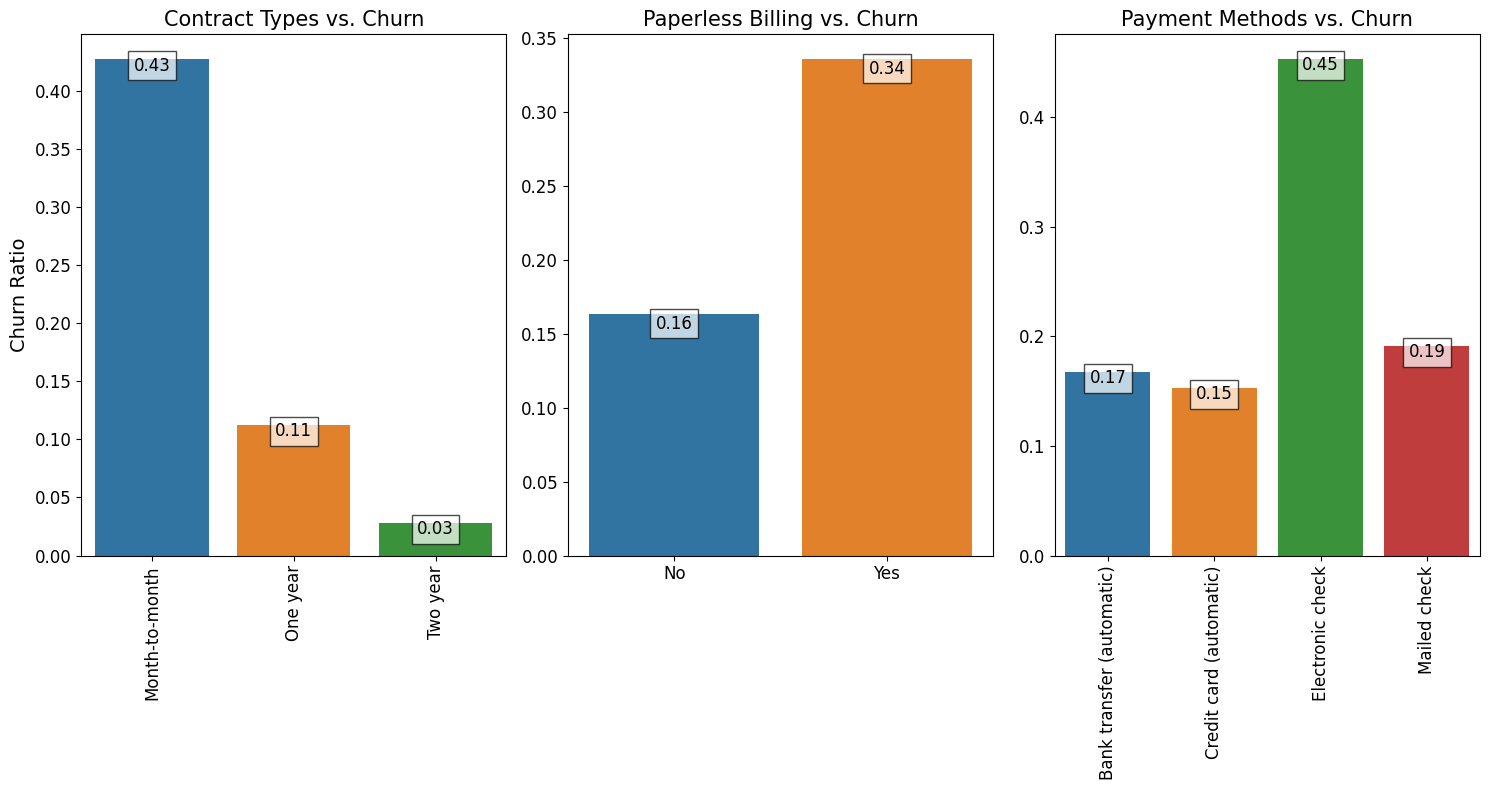

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(15, 8))

sns.barplot(data=ratio_cont, x='Contract', y='churn_ratio', ax=axs[0])
sns.barplot(data=ratio_pless, x='PaperlessBilling', y='churn_ratio', ax=axs[1])
sns.barplot(data=ratio_pm, x='PaymentMethod', y='churn_ratio', ax=axs[2])

axs[0].set_title('Contract Types vs. Churn', fontsize=15)
axs[0].set_xlabel('')
axs[0].set_ylabel('Churn Ratio', fontsize=14)
axs[0].tick_params(axis='x', labelsize=12, rotation=90)


axs[1].set_title('Paperless Billing vs. Churn', fontsize=15)
axs[1].set_xlabel('')
axs[1].set_ylabel('')
axs[1].tick_params(axis='x', labelsize=12)

axs[2].set_title('Payment Methods vs. Churn', fontsize=15)
axs[2].set_xlabel('')
axs[2].set_ylabel('')
axs[2].tick_params(axis='x', labelsize=12, rotation=90)

for i in range(3):
    axs[i].tick_params(axis='y', labelsize=12)
    

for i, r in enumerate(ratio_cont['churn_ratio']):
    axs[0].text(i, r-0.01, f'{r:.2f}', ha='center', fontsize=12,
                   bbox=dict(facecolor='white', alpha=0.7))

for i, r in enumerate(ratio_pless['churn_ratio']):
    axs[1].text(i, r-0.01, f'{r:.2f}', ha='center', fontsize=12,
                   bbox=dict(facecolor='white', alpha=0.7))
    
for i, r in enumerate(ratio_pm['churn_ratio']):
    axs[2].text(i, r-0.01, f'{r:.2f}', ha='center', fontsize=12,
                   bbox=dict(facecolor='white', alpha=0.7))

title = 'features_3.png'
fig.tight_layout()
fig.savefig(figure_path+title, dpi=200, bbox_inches='tight')
fig.show()

In [16]:
out_dir = 'processed'
os.makedirs(out_dir, exist_ok=True)

df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})
df['PaperlessBilling'] = df['PaperlessBilling'].map({'Yes':1, 'No':0})
df['PhoneService'] = df['PhoneService'].map({'Yes':1, 'No':0})

df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

df_proc = df[['Partner', 'Dependents', 'tenure', 'PhoneService', 
              'MultipleLines', 'InternetService','OnlineSecurity', 
              'OnlineBackup', 'DeviceProtection', 'TechSupport', 
              'Contract', 'PaperlessBilling', 'PaymentMethod', 
              'MonthlyCharges', 'TotalCharges', 'Churn']]

df_orig = df.copy()
df_orig.to_csv(out_dir + '/orig.csv')
df_proc.to_csv(out_dir + '/processed.csv')